<a href="https://colab.research.google.com/github/ZvoneST/pytorch-labs/blob/master/lovro_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Classifying Names with a Character-Level RNN


Adapted from [pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:


**Recommended Reading:**

To know more about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness) shows a bunch of real life examples
-  [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs) is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

   You can download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and put it in your drive or you can also add this drive folder to your own google drive account : https://drive.google.com/open?id=1Ht_snd9YSON7d1wv8whWwqmfqdXmjOUJ

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
## SETUP
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/CEA_EDF_INRIA_NLP
!ls

/content/drive/.shortcut-targets-by-id/1Ht_snd9YSON7d1wv8whWwqmfqdXmjOUJ/CEA_EDF_INRIA_NLP
data  img  NLP-attention


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

all_files = 'data/names/*.txt'

In [ ]:
def findFiles(path): return glob.glob(path)



print(findFiles(all_files))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(all_files):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/Irish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
n_categories

18

In [ ]:
all_categories

['Italian',
 'Russian',
 'Japanese',
 'Portuguese',
 'Arabic',
 'Greek',
 'Spanish',
 'Scottish',
 'English',
 'Korean',
 'Chinese',
 'Vietnamese',
 'Czech',
 'Dutch',
 'French',
 'German',
 'Polish',
 'Irish']

Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [ ]:
len(all_letters)

57

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users tutorial <http://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

<img src=https://i.imgur.com/Z2xbySO.png>
 

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # TODO (check the graph and `forward` for hints)
        combined_size = input_size + hidden_size
        # fully connected layers
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # input.shape (N, input_size)
        # hidden.shape (N, hidden_size)
        # combined.shape (N, input_size + hidden_size)
        # TODO
        # Define combined as concatenation of input and hidden
        # Follow the computational paths:
        # 1) combined -> i2o -> log_softmax (output)
        # 2) combined -> i2h (output)
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)        
        output = self.log_softmax(self.i2o(combined))
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
torch.cat?

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
input.shape

torch.Size([1, 57])

In [ ]:
print(output)

tensor([[-2.8825, -2.8983, -2.8700, -2.9337, -2.8141, -2.8534, -2.7813, -2.9558,
         -2.8307, -2.9282, -3.0335, -2.8218, -2.9046, -2.8982, -2.9137, -2.9674,
         -2.9095, -2.8618]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
output.shape

torch.Size([1, 18])

In [ ]:
print(next_hidden)

tensor([[-4.6001e-03,  1.9768e-02,  8.2175e-02, -4.8114e-02,  5.2928e-02,
          7.8524e-02, -4.8080e-02,  6.3420e-02, -7.5854e-02,  7.5625e-02,
         -5.8039e-02,  8.7280e-02,  9.4961e-02, -1.8133e-02,  1.6880e-03,
         -2.6843e-02, -1.4085e-04,  6.7793e-03, -6.7045e-03, -9.2897e-02,
         -9.0620e-02,  3.5192e-02,  2.4944e-02,  1.1936e-02, -5.7100e-02,
          9.5126e-02, -2.4973e-02, -1.1426e-01,  6.8571e-02, -1.0408e-01,
          4.4772e-02,  3.0164e-02,  1.0065e-01, -6.2011e-02,  5.3896e-02,
         -2.3636e-02,  1.1664e-01,  1.3720e-02, -1.0030e-01,  5.4241e-03,
          2.9560e-03,  1.2716e-02, -1.0080e-01, -9.8510e-03, -1.9753e-02,
          8.5582e-02,  1.9917e-02,  2.2335e-04, -6.0818e-03,  2.6871e-02,
          8.5418e-03,  3.8643e-02, -9.8794e-02,  5.5020e-02,  6.8396e-02,
         -5.6759e-02,  7.9917e-02,  6.3515e-02,  5.5686e-04,  3.4445e-02,
          3.3028e-02, -1.2388e-02, -1.0065e-02,  5.8960e-02, -1.4500e-01,
         -7.0919e-02, -1.0137e-01,  1.

In [ ]:
next_hidden.shape

torch.Size([1, 128])

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8825, -2.8983, -2.8700, -2.9337, -2.8141, -2.8534, -2.7813, -2.9558,
         -2.8307, -2.9282, -3.0335, -2.8218, -2.9046, -2.8982, -2.9137, -2.9674,
         -2.9095, -2.8618]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
input.shape

torch.Size([6, 1, 57])

In [ ]:
output.shape

torch.Size([1, 18])

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 6)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Sokolofsky
category = Dutch / line = Penners
category = German / line = Wernher
category = Chinese / line = Song
category = Scottish / line = Martin
category = Korean / line = Yu
category = Czech / line = Timpy
category = German / line = Baumann
category = English / line = Boulton
category = English / line = Rampling


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(),lr = learning_rate)
def train(category_tensor, line_tensor):
    # TODO
    # initialize the hidden state (hint: check the rnn class)
    hidden = rnn.initHidden()

    # TODO
    # zero the gradients
    optimizer.zero_grad()

    # get output and hidden state for each letter
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # TODO
    # calculate the loss between `output` and `category_tensor`
    loss = criterion(output, category_tensor)
    # back-propagate (calculate gradients)
    loss.backward()

    # update parameters (optimizer step)
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.9357 Poirier / German ✗ (French)
10000 10% (0m 9s) 1.7389 Pae / Chinese ✗ (Korean)
15000 15% (0m 13s) 1.6135 Nghiem / Vietnamese ✓
20000 20% (0m 17s) 1.9723 Nguyen / Vietnamese ✓
25000 25% (0m 21s) 1.3621 Meeuwsen / Dutch ✓
30000 30% (0m 26s) 0.9617 Bueren / Dutch ✓
35000 35% (0m 30s) 2.9745 Samuel / Arabic ✗ (French)
40000 40% (0m 34s) 0.9666 Suh / Korean ✓
45000 45% (0m 38s) 0.1772 Paloumbas / Greek ✓
50000 50% (0m 43s) 1.1227 Favager / French ✓
55000 55% (0m 47s) 0.5193 Mitsuharu / Japanese ✓
60000 60% (0m 51s) 1.1937 Ilsley / English ✓
65000 65% (0m 56s) 2.2116 Koza / Japanese ✗ (Czech)
70000 70% (1m 0s) 0.4222 Mifsud / Arabic ✓
75000 75% (1m 4s) 2.2250 Klemper / Dutch ✗ (Czech)
80000 80% (1m 9s) 1.6201 Austen / Dutch ✗ (English)
85000 85% (1m 14s) 0.5800 Wallace / English ✓
90000 90% (1m 19s) 2.8339 Acquafredda / Spanish ✗ (Italian)
95000 95% (1m 23s) 2.8229 Falsh / German ✗ (English)
100000 100% (1m 27s) 0.5604 Moon / Korean ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




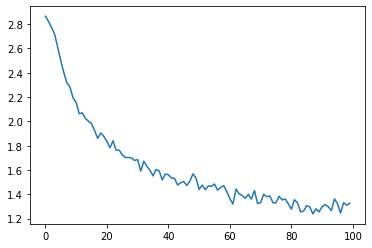

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




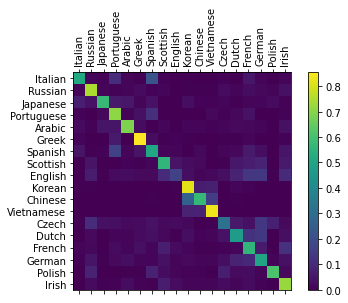

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.36) Russian
(-1.62) Czech
(-2.83) English

> Jackson
(-1.19) English
(-1.27) Scottish
(-1.42) Russian

> Satoshi
(-1.03) Italian
(-1.51) Arabic
(-2.35) Portuguese


In [ ]:
predict("Alejandro")


> Alejandro
(-0.66) Spanish
(-1.83) Russian
(-2.14) Italian


Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


